# Project Chicago: Transform ResStock BASELINE Results to 15 SFD prototypes (Elevate Energy)
Created on: 10/15/2020 \
By: 
 - Lixi Liu (Lixi.Liu@nrel.gov)
 - Tobi Adekanye

In [1]:
import pandas as pd
import numpy as np
import os
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results from S3 or Eagle
://S3/resbldg-datasets/chicagoeui

In [2]:
# local path to downloaded results
iteration = '_12' # <----- options: 'base', '_01'~'_11', '_national_2018'
result_path = '/Users/lliu2/Documents/Chicago retrofits/ResStock results/'
iteration_path = f'cookcnty_2007{iteration}/baseline' 
baseline_result = os.path.join(result_path,iteration_path,'results_up00.parquet')
print(f'Result and file storage path: {iteration_path}')


Result and file storage path: cookcnty_2007_12/baseline


In [3]:
### functions
def add_sqft_eui(df):
    global res
    sqft_map = {'0-499': 328,
                '500-749': 633,
                '750-999': 885,
                '1000-1499': 1220,
                '1500-1999': 1690,
                '2000-2499': 2176,
                '2500-2999': 2663,
                '3000-3999': 3301,
                '4000+': 8194}

    df['sqft'] = res['build_existing_model.geometry_floor_area'].map(sqft_map)
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    return df

print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, slice_by_df, row):
    """
    df: df to slice on
    slice_by_df: df used to do the slicing
    """
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i

print('func loaded: "get_res_by_prototype"')

func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


In [4]:
res = pd.read_parquet(baseline_result)
res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,35,2021-01-31 21:25:47,2021-01-31 21:27:04,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.195791,3.918606,2.105576,2.524894,17.363636,18.454545,18.896789,14.990603,5346.0,20.489417
1,2,10,2021-01-31 20:36:40,2021-01-31 20:37:53,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.412183,8.258352,6.093682,5.060321,15.636364,17.363636,30.913788,22.034863,6686.0,33.729591
2,3,40,2021-01-31 21:00:33,2021-01-31 21:01:58,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,8.016975,2.232581,2.479148,1.645619,15.545455,18.363636,16.396183,9.719040,6687.0,17.291352
3,4,23,2021-01-31 21:11:37,2021-01-31 21:14:45,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,82.138683,33.467491,19.032993,17.371771,15.000000,16.636364,167.293135,168.720538,67.0,262.157383
4,5,4,2021-01-31 21:28:55,2021-01-31 21:30:12,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,6.050258,1.883497,2.005345,1.363051,17.181818,18.454545,12.431255,8.999961,5322.0,14.317176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,27,2021-01-31 21:12:32,2021-01-31 21:13:48,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,9.143412,1.751807,1.184854,1.293943,15.272727,17.090909,17.495798,8.398064,3928.0,18.833847
39996,39997,31,2021-01-31 21:09:46,2021-01-31 21:11:07,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,10.306943,1.273525,2.017209,1.254633,16.000000,16.000000,34.574241,33.200340,5847.0,41.968056
39997,39998,8,2021-01-31 20:36:31,2021-01-31 20:41:00,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,162.030001,68.314896,34.679209,38.648836,19.181818,18.818182,241.469409,157.087861,3212.0,258.022776
39998,39999,8,2021-01-31 21:14:15,2021-01-31 21:15:44,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.848421,11.055973,2.241238,3.121428,15.818182,16.818182,33.109015,12.685046,4546.0,34.392692


In [5]:
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res

In [6]:
### HVAC cols changed after HVAC restructuring (implemented in Run5)
if iteration in ['base','_01','_02','_04']:
    cooling_col = 'build_existing_model.hvac_system_cooling_type'
else:
    cooling_col = 'build_existing_model.hvac_cooling_type'
if iteration in ['base','_01','_02','_04']:
    heating_col = 'build_existing_model.hvac_system_heating_natural_gas'
else:
    heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')


selected


### Check housing charateristics distributions

In [7]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iteration_path} - RESULT SUMMARY:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, iteration_path, 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, iteration_path)}')

>>> ResStock - cookcnty_2007_12/baseline - RESULT SUMMARY:

  * 39976 / 40000 samples ran successfully, 24 failed, efficacy: 99.9% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1            0.525790
2            0.260106
3            0.214103
N_failed    24.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry      0.715204
WoodStud     0.284796
N_failed    24.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59      0.235066
1960-79      0.255003
1980-99      0.137833
2000-09      0.076146
2010s        0.011682
<1940        0.284271
N_failed    24.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC     0.616595
Heat Pump      0.025615
None           0.052206
Room AC        0.305583
N_failed      24.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP        

In [34]:
f = pd.read_parquet('/Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf/baseline/results_up00.parquet')

f.to_csv(
    '/Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf/baseline/results_up00.csv',
    index=False
)

array(['SFD', 'MF 2-4 Flat', 'MF 5+ Units', 'SFA', 'MH', None],
      dtype=object)

### Add additional metrics to ResStock results

In [123]:
res['build_existing_model.units_modeled'] = pd.to_numeric(res['build_existing_model.units_modeled'])

# (1) get sqft, gas/elec/site eui
res = add_sqft_eui(res)


# (2) aggregate heating and cooling end uses in ResStock results
res['total_gas_heating'] = res['simulation_output_report.natural_gas_central_system_heating_therm'] +\
    res['simulation_output_report.natural_gas_heating_therm']

res['total_elec_heating'] = res['simulation_output_report.electricity_central_system_heating_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_heating_kwh'] +\
    res['simulation_output_report.electricity_fans_heating_kwh'] +\
    res['simulation_output_report.electricity_heating_kwh'] +\
    res['simulation_output_report.electricity_pumps_heating_kwh']

res['total_elec_cooling'] = res['simulation_output_report.electricity_central_system_cooling_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_cooling_kwh'] +\
    res['simulation_output_report.electricity_cooling_kwh'] +\
    res['simulation_output_report.electricity_fans_cooling_kwh'] +\
    res['simulation_output_report.electricity_pumps_cooling_kwh']


## EE prototype tags
res['vintage'] = 'Post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage'] = '1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage'] = 'Pre-1942'

res['stories'] = '2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '<2 stories'

res['bldg_type'] = res['build_existing_model.geometry_building_type_recs'].replace({
    'Single-Family Detached': 'SFD',
    'Multi-Family with 2 - 4 Units': 'MF 2-4 Flat',
    'Multi-Family with 5+ Units': 'MF 5+ Units',
    'Single-Family Attached': 'SFA',
    'Mobile Home': 'MH',
})
res['wall_type'] = res['build_existing_model.geometry_wall_type'].replace({
    'WoodStud': 'Frame',
})

## breakdowns of core bldg types
res['core_bldg_types'] = res['bldg_type'] + ' ' + res['wall_type'] + ' ' + res['vintage']
res['Priority Housing, Baseline'] = res['core_bldg_types']
res.loc[res['Priority Housing, Baseline'].str[:19] == 'MF 2-4 Flat Masonry',
       'Priority Housing, Baseline'] = 'MF 2-4 Flat Masonry'
res.loc[res['Priority Housing, Baseline'].str[:17] == 'MF 2-4 Flat Frame',
       'Priority Housing, Baseline'] = 'MF 2-4 Flat Frame'

print('new cols added to "res"')

res['Priority Housing, Baseline'].value_counts()

new cols added to "res"


SFD Masonry 1942-1978            6282
MF 2-4 Flat Masonry              5891
MF 5+ Units Masonry 1942-1978    5516
SFD Frame 1942-1978              4150
MF 5+ Units Masonry Post-1978    3851
MF 5+ Units Masonry Pre-1942     2959
SFD Frame Pre-1942               2128
MF 2-4 Flat Frame                1821
SFD Masonry Pre-1942             1647
SFD Frame Post-1978              1347
SFD Masonry Post-1978            1199
SFA Masonry Post-1978             596
SFA Frame Post-1978               553
SFA Masonry 1942-1978             472
SFA Frame 1942-1978               360
MF 5+ Units Frame Pre-1942        329
MF 5+ Units Frame 1942-1978       219
SFA Masonry Pre-1942              178
MF 5+ Units Frame Post-1978       173
MH Frame Post-1978                164
MH Frame 1942-1978                102
SFA Frame Pre-1942                 20
MH Frame Pre-1942                  19
Name: Priority Housing, Baseline, dtype: int64

In [44]:
res.groupby(['build_existing_model.chicago','build_existing_model.heating_fuel'])['building_id'].count() / \
res.groupby(['build_existing_model.chicago'])['building_id'].count()

build_existing_model.chicago  build_existing_model.heating_fuel
City of Chicago               Electricity                          0.140565
                              Fuel Oil                             0.001360
                              Natural Gas                          0.823489
                              None                                 0.014188
                              Other Fuel                           0.008794
                              Propane                              0.011604
Non-City Cook County          Electricity                          0.118839
                              Fuel Oil                             0.000391
                              Natural Gas                          0.861903
                              None                                 0.004968
                              Other Fuel                           0.005135
                              Propane                              0.008764
Name: building_id, dtype

In [42]:
res['bldg_factor'] = 1/res['build_existing_model.units_represented']
res.groupby(['build_existing_model.chicago','core_bldg_types'])['bldg_factor'].sum().to_frame()

bldg_factor
build_existing_model.chicago core_bldg_types                           
City of Chicago              MF 2-4 Flat Frame 1942-1978      68.916667
                             MF 2-4 Flat Frame post-1978      30.750000
                             MF 2-4 Flat Frame pre-1942      517.083333
                             MF 2-4 Flat Masonry 1942-1978   614.416667
                             MF 2-4 Flat Masonry post-1978   232.000000
                             MF 2-4 Flat Masonry pre-1942    924.166667
                             MF 5+ Units Frame 1942-1978      10.439220
                             MF 5+ Units Frame post-1978       4.833201
                             MF 5+ Units Frame pre-1942       21.991733
                             MF 5+ Units Masonry 1942-1978   196.462037
                             MF 5+ Units Masonry post-1978   122.262831
                             MF 5+ Units Masonry pre-1942    208.592857
                             MH Frame 1942-1978               25.000000
                             MH Frame post-1978               20.000000
                             MH Frame pre-1942                13.000000
                             SFA Frame 1942-1978              11.455833
                             SFA Frame post-1978              15.469127
                             SFA Frame pre-1942                1.505556
                             SFA Masonry 1942-1978            21.981825
                             SFA Masonry post-1978            18.642540
                             SFA Masonry pre-1942             15.269841
                             SFD Frame 1942-1978            1216.000000
                             SFD Frame post-1978             293.000000
                             SFD Frame pre-1942             1317.000000
                             SFD Masonry 1942-1978          2162.000000
                             SFD Masonry post-1978           258.000000
                             SFD Masonry pre-1942            959.000000
Non-City Cook County         MF 2-4 Flat Frame 1942-1978      19.333333
                             MF 2-4 Flat Frame post-1978      11.833333
                             MF 2-4 Flat Frame pre-1942       76.833333
                             MF 2-4 Flat Masonry 1942-1978   254.166667
                             MF 2-4 Flat Masonry post-1978   114.500000
                             MF 2-4 Flat Masonry pre-1942    127.166667
                             MF 5+ Units Frame 1942-1978       5.703439
                             MF 5+ Units Frame post-1978       4.355622
                             MF 5+ Units Frame pre-1942        3.367262
                             MF 5+ Units Masonry 1942-1978   178.292328
                             MF 5+ Units Masonry post-1978    99.158333
                             MF 5+ Units Masonry pre-1942     30.245966
                             MH Frame 1942-1978               77.000000
                             MH Frame post-1978              144.000000
                             MH Frame pre-1942                 6.000000
                             SFA Frame 1942-1978              26.511310
                             SFA Frame post-1978              44.536627
                             SFA Frame pre-1942                0.436111
                             SFA Masonry 1942-1978            28.134246
                             SFA Masonry post-1978            45.306468
                             SFA Masonry pre-1942              2.559881
                             SFD Frame 1942-1978            2934.000000
                             SFD Frame post-1978            1054.000000
                             SFD Frame pre-1942              811.000000
                             SFD Masonry 1942-1978          4120.000000
                             SFD Masonry post-1978           941.000000
                             SFD Masonry pre-1942            688.000000

In [124]:
def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

In [125]:
# (3) Utility costs & Carbon emissions
NG_rate_multiplier = 1 # <----

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh (0.2446 tons/mbtu)

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 * 12
NGH_fixed = 21.51 * 12
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm (0.0532 tons/mbtu)

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[res['build_existing_model.heating_fuel']=='Natural Gas',
       'gas_rate'] = GH_rate
res.loc[res['build_existing_model.heating_fuel']=='Natural Gas',
       'gas_fixed'] = GH_fixed
res.loc[res['build_existing_model.heating_fuel']=='Electricity',
        'elec_rate'] = EH_rate
res.loc[res['build_existing_model.heating_fuel']=='Electricity',
        'elec_fixed'] = EH_fixed

# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan
    
# get annual totals
res = get_annual_totals(res)
    
res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,5_core_bldg_types,heating_fuel,"Priority Housing, Baseline"
0,1,35,2021-01-31 21:25:47,2021-01-31 21:27:04,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1140.676553,1483.769396,2624.445949,5.152236,8.679975,13.832212,SFD Masonry 1942-1978,Natural Gas,SFD Masonry 1942-1978
1,2,10,2021-01-31 20:36:40,2021-01-31 20:37:53,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2380.765090,3049.069331,5429.834421,15.857394,19.032511,34.889905,MF 2-4 Flat Masonry,Natural Gas,MF 2-4 Flat Masonry
2,3,40,2021-01-31 21:00:33,2021-01-31 21:01:58,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1429.144940,1508.246077,2937.391017,7.642462,8.841858,16.484320,SFD Masonry Post-1978,Natural Gas,SFD Masonry Post-1978
3,4,23,2021-01-31 21:11:37,2021-01-31 21:14:45,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,5132.185741,11529.428456,16661.614196,39.609240,75.119664,114.728904,MF 5+ Units Masonry 1942-1978,Natural Gas,MF 5+ Units Masonry 1942-1978
4,5,4,2021-01-31 21:28:55,2021-01-31 21:30:12,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1219.847134,1125.083549,2344.930683,5.835682,6.307709,12.143392,SFD Frame Post-1978,Natural Gas,SFD Frame Post-1978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,27,2021-01-31 21:12:32,2021-01-31 21:13:48,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1894.759923,1312.024582,3206.784505,11.661918,7.544094,19.206012,SFD Masonry Pre-1942,Natural Gas,SFD Masonry Pre-1942
39996,39997,31,2021-01-31 21:09:46,2021-01-31 21:11:07,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,1405.402192,1167.444637,2572.846828,7.437500,6.587876,14.025376,MH Frame 1942-1978,Natural Gas,MH Frame 1942-1978
39997,39998,8,2021-01-31 20:36:31,2021-01-31 20:41:00,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,7467.277035,23543.009002,31010.286037,59.767091,154.574736,214.341827,MF 5+ Units Masonry Post-1978,Natural Gas,MF 5+ Units Masonry Post-1978
39998,39999,8,2021-01-31 21:14:15,2021-01-31 21:15:44,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.000835,2656.072700,2731.155577,5387.228277,18.234008,16.929902,35.163910,SFD Masonry Pre-1942,Natural Gas,SFD Masonry Pre-1942


In [188]:
wt =  2173432 /40000
core_bldgs = ['SFD Masonry Pre-1942', 'SFD Frame Pre-1942', 'SFD Masonry 1942-1978', 
              'MF 2-4 Flat Masonry', 'MF 2-4 Flat Frame']
res['heating_fuel'] = res['build_existing_model.heating_fuel']
res2 = res.loc[
    (res['build_existing_model.chicago']=='City of Chicago') &
    (res['heating_fuel'].isin(['Natural Gas','Electricity'])) &
    (res['Priority Housing, Baseline'].isin(core_bldgs))
              ]

ress = res2.groupby(['Priority Housing, Baseline','heating_fuel']).agg({
#     'simulation_output_report.total_site_energy_mbtu': 'mean',
    'site_eui': 'mean',
    'ann_energy_cost': 'mean',
    'ann_metric_ton_co2e': 'mean',
    'build_existing_model.sample_weight': 'sum',
})


ress = ress.rename(columns={
#     'simulation_output_report.total_site_energy_mbtu':'Mean Site Energy mmBtu',
    'site_eui': 'Mean Site EUI kBtu/sqft',
    'ann_energy_cost': 'Mean Ann Utility Cost',
    'ann_metric_ton_co2e': 'Mean Ann Metric Ton CO2E',
    'build_existing_model.sample_weight': 'Applicable Housing Units',
})

ress

Mean Site EUI kBtu/sqft  \
Priority Housing, Baseline heating_fuel                            
MF 2-4 Flat Frame          Electricity                209.696959   
                           Natural Gas                322.300135   
MF 2-4 Flat Masonry        Electricity                218.981117   
                           Natural Gas                294.337819   
SFD Frame Pre-1942         Electricity                 96.315026   
                           Natural Gas                128.484111   
SFD Masonry 1942-1978      Electricity                 69.107911   
                           Natural Gas                 94.623041   
SFD Masonry Pre-1942       Electricity                 85.032415   
                           Natural Gas                119.724570   

                                         Mean Ann Utility Cost  \
Priority Housing, Baseline heating_fuel                          
MF 2-4 Flat Frame          Electricity             7520.393176   
                           Natural Gas             4765.296839   
MF 2-4 Flat Masonry        Electricity             6915.062701   
                           Natural Gas             4616.107376   
SFD Frame Pre-1942         Electricity             4882.356605   
                           Natural Gas             3190.491598   
SFD Masonry 1942-1978      Electricity             3840.877562   
                           Natural Gas             2623.521745   
SFD Masonry Pre-1942       Electricity             5025.304173   
                           Natural Gas             3161.596004   

                                         Mean Ann Metric Ton CO2E  \
Priority Housing, Baseline heating_fuel                             
MF 2-4 Flat Frame          Electricity                  56.492605   
                           Natural Gas                  30.463238   
MF 2-4 Flat Masonry        Electricity                  51.670069   
                           Natural Gas                  29.001358   
SFD Frame Pre-1942         Electricity                  35.362241   
                           Natural Gas                  18.711392   
SFD Masonry 1942-1978      Electricity                  27.168630   
                           Natural Gas                  14.120687   
SFD Masonry Pre-1942       Electricity                  36.617259   
                           Natural Gas                  18.357149   

                                         Applicable Housing Units  
Priority Housing, Baseline heating_fuel                            
MF 2-4 Flat Frame          Electricity                4075.186875  
                           Natural Gas               77917.573050  
MF 2-4 Flat Masonry        Electricity               15105.359350  
                           Natural Gas              225765.352875  
SFD Frame Pre-1942         Electricity                2119.097175  
                           Natural Gas               68517.475325  
SFD Masonry 1942-1978      Electricity                4075.186875  
                           Natural Gas              112149.142800  
SFD Masonry Pre-1942       Electricity                1412.731450  
                           Natural Gas               49554.272400

<ipython-input-189-08640280968c>:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles,     # The line objects


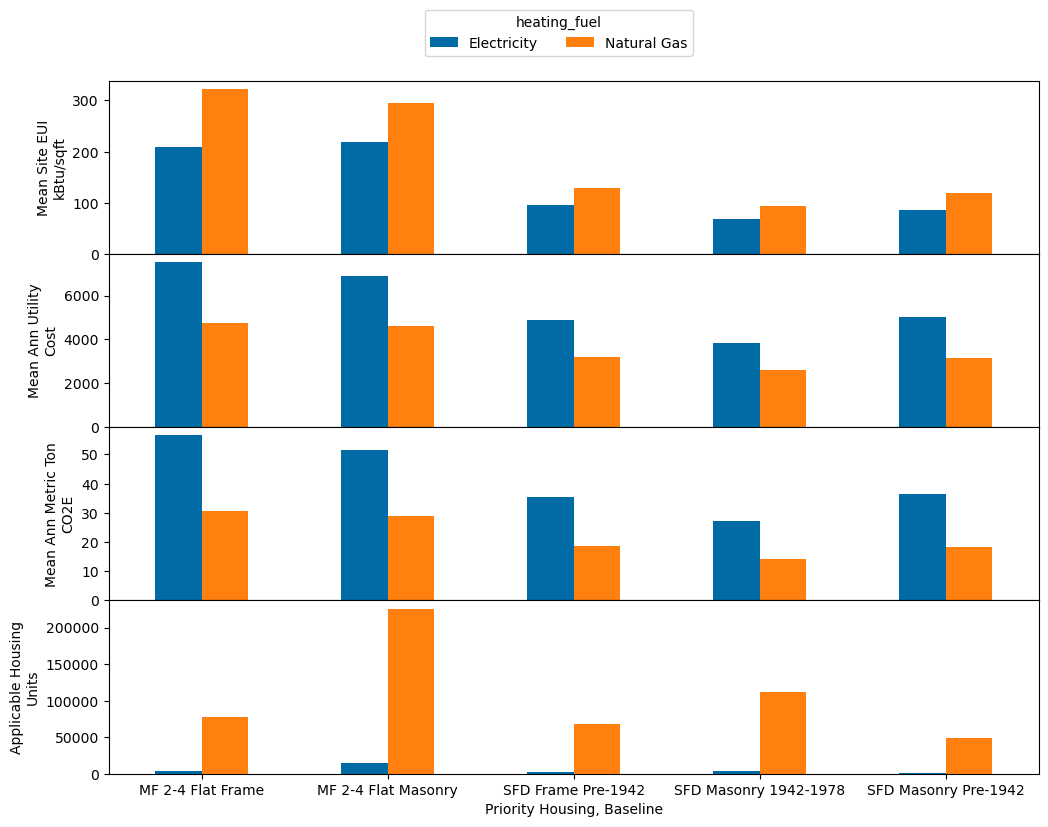

In [189]:
import matplotlib.pyplot as plt
from textwrap import wrap

fig, axs = plt.subplots(ress.shape[1], sharex=True, figsize=(12,9))

for i, col in enumerate(ress.columns):
    ress[col].unstack(level=1).plot(kind='bar', ax=axs[i], legend=False, rot=0)
    axs[i].set_ylabel('\n'.join(wrap(col, 20)))
    

handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles,     # The line objects
           labels=labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=None,    # Small spacing around legend box
           title="heating_fuel",  # Title for the legend
           ncol=2,
           bbox_to_anchor=(0.5, 0.9)
           )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)


### Get results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags to ResStock results as prototypes overlap in chars

In [11]:
## Elevate Energy prototype chars
groups = pd.read_csv(os.path.join(result_path,'Groups.csv'))
print('prototypes loaded')

prototypes loaded


In [12]:
Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

### (1) get median consumption
for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.loc[i, 'count'] = len(res_group_i)
        else:
            groups.loc[i, metric] = res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> median consumption computed')

### (2) get mean consumption
for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> mean consumption computed')



>> median consumption computed
>> mean consumption computed


In [13]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.loc[i, metric] = res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

print('>> median & mean sqft & eui computed:')

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]


>> median & mean sqft & eui computed:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2400.185629,769.123429,831.143354,0.380119,0.407209,8910.266906,10013.469528,4.306714,4.925382
2,Masonry All Years Split Level,1690.0,1999.250910,1096.207410,1223.012892,0.655505,0.700019,9246.924934,10660.410431,5.459259,6.226899
3,Masonry Post-1978 2 or more stories,3301.0,4089.133733,1220.759650,1273.278600,0.362462,0.387973,11784.659744,13803.908343,3.505254,4.039219
4,Masonry 1942-1978 Less than 2 Stories,1690.0,1679.967057,982.514701,1065.771042,0.648249,0.680789,8729.086804,9729.934448,5.642093,6.378779
5,Masonry 1942-1978 2 or more stories,2176.0,2388.074307,1519.475307,1605.061857,0.757074,0.759763,10532.769731,12253.045381,5.164577,6.002471
6,Masonry Pre-1942 less than 2 stories,1220.0,1463.119279,1289.160094,1397.503440,0.996135,1.026221,9257.434434,10293.841056,7.138953,7.695182
7,Masonry Pre-1942 2 or more stories,2176.0,2551.521219,1801.082440,1948.367232,0.864987,0.889762,11389.449450,13860.768654,5.462812,6.504520
8,Frame Post-1978 Less than 2 stories,2176.0,2247.898477,822.391439,899.540971,0.429009,0.458847,8782.942510,9871.270311,4.631596,5.141148
9,Frame Post-1978 Split Level,2176.0,2999.643446,1025.861239,1139.105646,0.433238,0.455263,9844.079935,11770.138509,4.115476,4.698315


In [17]:
##### (4) get heating and cooling end uses to "groups"
Metric_map1 = ['frac_gas_heating', 'frac_elec_heating', 'frac_elec_cooling']
Metric_map2 = {'size_heating_kbut_h': 'simulation_output_report.size_heating_system_kbtu_h',
               'size_cooling_kbut_h': 'simulation_output_report.size_cooling_system_kbtu_h'}

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, res, row)
    
    ### (4.1) get fractions
    groups.loc[i, 'frac_gas_heating'] = res_group_i['total_gas_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_natural_gas_therm'].mean()

    groups.loc[i, 'frac_elec_heating'] = res_group_i['total_elec_heating'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    groups.loc[i, 'frac_elec_cooling'] = res_group_i['total_elec_cooling'].mean() / \
        res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    ### (4.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.loc[i, metric] = res_group_i[res_var].mean()

print('computed')

computed


In [18]:
### (5) get heating & cooling and floor area char breakdowns

House = []
House_chars = [cooling_col, heating_col,
              #'build_existing_model.geometry_floor_area',
              'build_existing_model.insulation_unfinished_attic']

for i, row in groups.iterrows():
    
    res_group_i = get_res_by_prototype(res, res, row)
    
    Ns = len(res_group_i)
    Hi = []
    for char in House_chars:
        Nchar = res_group_i.groupby(char)['building_id'].count()/Ns # fractions
        Nchar = Nchar.rename('fraction').to_frame()
        Nchar['housing_char'] = Nchar.index.name
        Hi.append(Nchar)
    
    Hi = pd.concat(Hi, axis=0)
    Hi.index.name = 'sub_char'
    Hi = Hi.reset_index()
    Hi['HousingGroupNo'] = row['HousingGroupNo']
    
    House.append(Hi)
    
House = pd.concat(House, axis=0)
House = pd.pivot_table(House, values='fraction', index=['HousingGroupNo'],
                    columns=['housing_char','sub_char'], aggfunc=np.sum)

print('computed')

computed


In [19]:
## Combine "groups" + "House" into "Out" for export
out = groups.drop(['Stories','WallType','Vintage'], axis=1)
out = pd.concat([out.set_index('HousingGroupNo')], axis=1, keys=['none']).join(House)
out

none  \
                                     HousingGroupName   
HousingGroupNo                                          
1               Masonry Post-1978 less than 2 stories   
2                       Masonry All Years Split Level   
3                 Masonry Post-1978 2 or more stories   
4               Masonry 1942-1978 Less than 2 Stories   
5                 Masonry 1942-1978 2 or more stories   
6                Masonry Pre-1942 less than 2 stories   
7                  Masonry Pre-1942 2 or more stories   
8                 Frame Post-1978 Less than 2 stories   
9                         Frame Post-1978 Split Level   
10                  Frame Post-1978 2 or more stories   
11                Frame 1942-1978 less than 2 stories   
12                         Frame Pre-1942 Split Level   
13                  Frame 1942-1978 2 or more stories   
14                 Frame Pre-1942 less than 2 stories   
15                   Frame Pre-1942 2 or more stories   

                                                                            \
               Non-normalized gas usage Non-normalized elec. usage   count   
HousingGroupNo                                                               
1                                  1133                      10282   668.0   
2                                  1416                       9661  9067.0   
3                                  1812                      18225   501.0   
4                                  1210                       8779  5464.0   
5                                  1427                      10549   794.0   
6                                  1504                       9299   721.0   
7                                  2044                      13272   919.0   
8                                  1054                       9353   591.0   
9                                  1168                      10445  1335.0   
10                                 1422                      13495   744.0   
11                                 1176                       9213  2980.0   
12                                 1297                       9964  2128.0   
13                                 1530                      12543  1119.0   
14                                 1340                       9103   703.0   
15                                 1753                      11967  1425.0   

                                                                            \
                 median gas   median elec Gas Diff-med(%) Elec Diff-med(%)   
HousingGroupNo                                                               
1                769.123429   8910.266906       32.116202        13.341112   
2               1096.207410   9246.924934       22.584222         4.286048   
3               1220.759650  11784.659744       32.629158        35.337944   
4                982.514701   8729.086804       18.800438         0.568552   
5               1519.475307  10532.769731       -6.480400         0.153856   
6               1289.160094   9257.434434       14.284568         0.446990   
7               1801.082440  11389.449450       11.884421        14.184377   
8                822.391439   8782.942510       21.974247         6.094916   
9               1025.861239   9844.079935       12.169414         5.753184   
10              1262.991881  10838.526485       11.182006        19.684872   
11              1037.993048   8548.853785       11.735285         7.208794   
12              1742.206909  10061.213042      -34.325899        -0.975643   
13              1631.248839  10002.949543       -6.617571        20.250741   
14              1329.418422   8670.070681        0.789670         4.755897   
15              1913.652978  10873.297884       -9.164460         9.139317   

                                           ...  \
                   mean gas     mean elec  ...   
HousingGroupNo                             ...   
1                831.143354  10013.469528  ...   
2           

### Write output to folder

In [ ]:
#out_name = "Groups_results" + "_" + baseline_result.split("_")[2]
out.to_csv(os.path.join(result_path, iteration_path, 'baseline_prototype_results.csv'), index=True)
print(f'file saved to:\n  {os.path.join(result_path, iteration_path)}')

### Additional slicing for diagnosis

In [155]:
### get sqft distr by building type and vintage
res_sqft_distr = res.groupby(['build_existing_model.geometry_building_type_recs', 'build_existing_model.vintage_acs',
    'build_existing_model.geometry_floor_area'])['building_id'].count().to_frame()

# normalize
res_sqft_distr = res_sqft_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)

# export
res_sqft_distr.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_floor_area.csv'), index=True)
print('sqft distr by vintage & bldg type exported')


sqft distr by vintage & bldg type exported


In [156]:
### get foundation type distr by building type, vintage
print('>> prevalence')
res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type','build_existing_model.vintage', 'build_existing_model.geometry_stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=-1)
display(res_found_distr)


>> prevalence


build_existing_model.geometry_foundation_type                                                                  Crawl  \
build_existing_model.geometry_wall_type build_existing_model.vintage build_existing_model.geometry_stories             
Masonry                                 1940s                        1                                      0.098513   
                                                                     2                                      0.005576   
                                                                     3                                           NaN   
                                        1950s                        1                                      0.104918   
                                                                     2                                      0.009508   
                                                                     3                                      0.000328   
                                        1960s                        1                                      0.156332   
                                                                     2                                      0.019789   
                                                                     3                                      0.001979   
                                        1970s                        1                                      0.136364   
                                                                     2                                      0.027597   
                                                                     3                                           NaN   
                                        1980s                        1                                      0.127586   
                                                                     2                                      0.079310   
                                                                     3                                      0.017241   
                                        1990s                        1                                      0.135870   
                                                                     2                                      0.051630   
                                                                     3                                      0.010870   
                                        2000s                        1                                      0.073009   
                                                                     2                                      0.042035   
                                                                     3                                      0.035398   
                                        2010s                        1                                      0.050847   
                                                                     2                                      0.101695   
                                                                     3                                           NaN   
                                        <1940                        1                                      0.067683   
                                                                     2                                      0.076829   
                                                                     3                                      0.009146   
WoodStud                                1940s                        1                                      0.130930   
                                                                     2                                      0.047438   
                                                                     3                                      0.001898   
                                        1950s                        1                                      0.099614   
                                        

In [157]:
print('\n>> gas usage')
res_found_gas = res[(res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached")
                   ].groupby(
    ['build_existing_model.geometry_wall_type', 'build_existing_model.vintage_acs', 
#     'build_existing_model.geometry_stories', 
     'build_existing_model.geometry_floor_area_bin',
    'build_existing_model.geometry_foundation_type'])[
    
#    'gas_eui'
#    'elec_eui'
    'simulation_output_report.total_site_natural_gas_therm'
#    'simulation_output_report.total_site_electricity_kwh'
    
].mean().to_frame()
res_found_gas = res_found_gas.unstack(level=-1)
#res_found_gas.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_foundation_elec_eui.csv'))
res_found_gas


>> gas usage


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_foundation_type                                                                                                                         Crawl   
build_existing_model.geometry_wall_type build_existing_model.vintage_acs build_existing_model.geometry_floor_area_bin                                                         
Masonry                                 1940-59                          0-1499                                                                              1157.631975      
                                                                         1500-2499                                                                           1699.527985      
                                                                         2500-3999                                                                           2346.331854      
                                                                         4000+                                                                               4019.868090      
                                        1960-79                          0-1499                                                                              1084.537861      
                                                                         1500-2499                                                                           1563.719644      
                                                                         2500-3999                                                                           2133.514432      
                                                                         4000+                                                                               3828.794245      
                                        1980-99                          0-1499                                                                               653.954470      
                                                                         1500-2499                                                                            978.692958      
                                                                         2500-3999                                                                           1436.626981      
                                                                         4000+                                                                               1929.850609      
                                        2000-09                          0-1499                                                                               697.284370      
                                                                         1500-2499                                                                            677.858967      
                                                                         2500-3999                                                                            927.977051      
                                                                         4000+                                                                               1584.865122      
                                        2010s                            0-1499                                                                                 0.000000      
                                                                         1500-2499                                                                                   NaN      
                                                                         2500-3999                                                                           1122.496701      
                                                                         4000+                                                                               1491.963346      
                                        <1940                            0-1499              

In [158]:
print('\n>> gas usage')
res_found_gas = res[(res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached")
                   ].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage', 
     'stories', 
#     'build_existing_model.geometry_floor_area_bin',
    'build_existing_model.geometry_foundation_type'])[
    
    'gas_eui'
#    'elec_eui'
#    'simulation_output_report.total_site_natural_gas_therm'
#    'simulation_output_report.total_site_electricity_kwh'
    
].mean().to_frame()
res_found_gas = res_found_gas.unstack(level=-1)
#res_found_gas.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_foundation_gas_eui2.csv'))
res_found_gas


>> gas usage


gas_eui  \
build_existing_model.geometry_foundation_type                          Crawl   
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  1.272644   
                                                     2: 2+ stories  1.031769   
                                        2: 1942-1978 1: <2 stories  0.914038   
                                                     2: 2+ stories  0.928529   
                                        3: post-1978 1: <2 stories  0.437912   
                                                     2: 2+ stories  0.417464   
WoodStud                                1: pre-1942  1: <2 stories  1.296271   
                                                     2: 2+ stories  1.139986   
                                        2: 1942-1978 1: <2 stories  0.938085   
                                                     2: 2+ stories  0.958861   
                                        3: post-1978 1: <2 stories  0.505384   
                                                     2: 2+ stories  0.495317   

                                                                                    \
build_existing_model.geometry_foundation_type                      Heated Basement   
build_existing_model.geometry_wall_type vintage_ee   stories                         
Masonry                                 1: pre-1942  1: <2 stories        0.692462   
                                                     2: 2+ stories        0.730389   
                                        2: 1942-1978 1: <2 stories        0.521870   
                                                     2: 2+ stories        0.642914   
                                        3: post-1978 1: <2 stories        0.300541   
                                                     2: 2+ stories        0.308480   
WoodStud                                1: pre-1942  1: <2 stories        0.784538   
                                                     2: 2+ stories        0.844437   
                                        2: 1942-1978 1: <2 stories        0.521504   
                                                     2: 2+ stories        0.737404   
                                        3: post-1978 1: <2 stories        0.341872   
                                                     2: 2+ stories        0.379533   

                                                                                  \
build_existing_model.geometry_foundation_type                      Pier and Beam   
build_existing_model.geometry_wall_type vintage_ee   stories                       
Masonry                                 1: pre-1942  1: <2 stories      1.439555   
                                                     2: 2+ stories      1.047704   
                                        2: 1942-1978 1: <2 stories      1.130533   
                                                     2: 2+ stories      1.351516   
                                        3: post-1978 1: <2 stories      0.626489   
                                                     2: 2+ stories      0.485163   
WoodStud                                1: pre-1942  1: <2 stories      1.438050   
                                                     2: 2+ stories      1.238473   
                                        2: 1942-1978 1: <2 stories      1.000301   
                                                     2: 2+ stories      1.036576   
                                        3: post-1978 1: <2 stories      0.593738   
                                                     2: 2+ stories      0.718021   

                                                                              \
build_existing_model.geometry_foundation_type                           Slab   
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.989707

In [159]:
### get foundation type distr by building type, vintage (EE prototype)
print('>> prevalence')
res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage', 'stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=-1)
display(res_found_distr)

print('\n>> gas usage')
res_found_gas = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.geometry_wall_type', 'vintage', 'stories',
    'build_existing_model.geometry_foundation_type'])[
    'simulation_output_report.total_site_natural_gas_therm'].mean().to_frame()
res_found_gas.unstack(level=-1)


>> prevalence


build_existing_model.geometry_foundation_type                          Crawl  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.067683   
                                                     2: 2+ stories  0.085976   
                                        2: 1942-1978 1: <2 stories  0.119367   
                                                     2: 2+ stories  0.013742   
                                        3: post-1978 1: <2 stories  0.105218   
                                                     2: 2+ stories  0.078700   
WoodStud                                1: pre-1942  1: <2 stories  0.050282   
                                                     2: 2+ stories  0.123590   
                                        2: 1942-1978 1: <2 stories  0.108319   
                                                     2: 2+ stories  0.044401   
                                        3: post-1978 1: <2 stories  0.076404   
                                                     2: 2+ stories  0.074157   

build_existing_model.geometry_foundation_type                       Heated Basement  \
build_existing_model.geometry_wall_type vintage_ee   stories                          
Masonry                                 1: pre-1942  1: <2 stories         0.142073   
                                                     2: 2+ stories         0.164634   
                                        2: 1942-1978 1: <2 stories         0.383030   
                                                     2: 2+ stories         0.059124   
                                        3: post-1978 1: <2 stories         0.211292   
                                                     2: 2+ stories         0.159110   
WoodStud                                1: pre-1942  1: <2 stories         0.093985   
                                                     2: 2+ stories         0.163064   
                                        2: 1942-1978 1: <2 stories         0.242742   
                                                     2: 2+ stories         0.090998   
                                        3: post-1978 1: <2 stories         0.155805   
                                                     2: 2+ stories         0.197753   

build_existing_model.geometry_foundation_type                       Pier and Beam  \
build_existing_model.geometry_wall_type vintage_ee   stories                        
Masonry                                 1: pre-1942  1: <2 stories       0.008537   
                                                     2: 2+ stories       0.007317   
                                        2: 1942-1978 1: <2 stories       0.011186   
                                                     2: 2+ stories       0.000959   
                                        3: post-1978 1: <2 stories       0.005133   
                                                     2: 2+ stories       0.003422   
WoodStud                                1: pre-1942  1: <2 stories       0.001410   
                                                     2: 2+ stories       0.003759   
                                        2: 1942-1978 1: <2 stories       0.011222   
                                                     2: 2+ stories       0.003659   
                                        3: post-1978 1: <2 stories       0.001498   
                                                     2: 2+ stories       0.003745   

build_existing_model.geometry_foundation_type                           Slab  \
build_existing_model.geometry_wall_type vintage_ee   stories                   
Masonry                                 1: pre-1942  1: <2 stories  0.034756   
                                                     2: 2+ stories  0.051220   
                                        2: 1942-1978 1: <2 stories  0.179291   
                                                     2: 2+ stories  0


>> gas usage


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_foundation_type                                                                      Crawl   
build_existing_model.geometry_wall_type vintage_ee   stories                                                               
Masonry                                 1: pre-1942  1: <2 stories                                        1879.419163      
                                                     2: 2+ stories                                        2517.641955      
                                        2: 1942-1978 1: <2 stories                                        1473.546246      
                                                     2: 2+ stories                                        2026.977676      
                                        3: post-1978 1: <2 stories                                         918.866711      
                                                     2: 2+ stories                                        1295.435010      
WoodStud                                1: pre-1942  1: <2 stories                                        1763.278654      
                                                     2: 2+ stories                                        2305.232097      
                                        2: 1942-1978 1: <2 stories                                        1481.494812      
                                                     2: 2+ stories                                        1885.006132      
                                        3: post-1978 1: <2 stories                                        1082.607796      
                                                     2: 2+ stories                                        1582.559962      

                                                                                    \
build_existing_model.geometry_foundation_type                      Heated Basement   
build_existing_model.geometry_wall_type vintage_ee   stories                         
Masonry                                 1: pre-1942  1: <2 stories      901.041090   
                                                     2: 2+ stories     1557.986760   
                                        2: 1942-1978 1: <2 stories      794.368441   
                                                     2: 2+ stories     1361.966261   
                                        3: post-1978 1: <2 stories      589.006773   
                                                     2: 2+ stories     1069.467528   
WoodStud                                1: pre-1942  1: <2 stories     1014.909945   
                                                     2: 2+ stories     1631.154988   
                                        2: 1942-1978 1: <2 stories      814.115025   
                                                     2: 2+ stories     1466.111068   
                                        3: post-1978 1: <2 stories      633.588365   
                                                     2: 2+ stories     1039.807953   

                                                                                  \
build_existing_model.geometry_foundation_type                      Pier and Beam   
build_existing_model.geometry_wall_type vintage_ee   stories                       
Masonry                                 1: pre-1942  1: <2 stories   2137.064405   
                                                     2: 2+ stories   2749.532569   
                                        2: 1942-1978 1: <2 stories   1654.525639   
                                                     2: 2+ stories   2083.752791   
                                        3: post-1978 1: <2 stories    953.255507   
                                                     2: 2+ stories   1570.335357   
WoodStud                                1: pre-1942  1: <2 stories   2834.273081   
                                                     2: 2+ stories   2489.8

In [160]:
para = 'gas_eui'
print(f'>> for {para}')
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_wall_type','build_existing_model.geometry_stories',
'build_existing_model.vintage'])[para].mean().unstack(level=-1)

>> for gas_eui


build_existing_model.vintage                                                      1940s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.695991   
                                        2                                      0.794845   
                                        3                                      0.595071   
WoodStud                                1                                      0.840806   
                                        2                                      0.934351   
                                        3                                      0.976320   

build_existing_model.vintage                                                      1950s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.699202   
                                        2                                      0.760762   
                                        3                                      0.788718   
WoodStud                                1                                      0.819136   
                                        2                                      0.952725   
                                        3                                      1.056119   

build_existing_model.vintage                                                      1960s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.645974   
                                        2                                      0.743425   
                                        3                                      0.781771   
WoodStud                                1                                      0.706532   
                                        2                                      0.850977   
                                        3                                      0.889152   

build_existing_model.vintage                                                      1970s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.643957   
                                        2                                      0.716438   
                                        3                                      0.985895   
WoodStud                                1                                      0.580269   
                                        2                                      0.650343   
                                        3                                      0.931227   

build_existing_model.vintage                                                      1980s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.470759   
                                        2                                      0.518264   
                                        3                                      0.333591   
WoodStud                                1                                      0.499442   
                                        2                                      0.512049   
                                        3                                      0.629297   

build_existing_model.vintage                                                      1990s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories             
Masonry                                 1                                      0.468449   
                                        2                                      0.5

In [161]:
para = 'simulation_output_report.total_site_natural_gas_therm'
print(f'>> for {para}')
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_wall_type','build_existing_model.geometry_stories',
'build_existing_model.vintage'])[para].mean().unstack(level=-1)

>> for simulation_output_report.total_site_natural_gas_therm


build_existing_model.vintage                                                         1940s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1050.459870   
                                        2                                      1542.097349   
                                        3                                      1964.328928   
WoodStud                                1                                      1217.603081   
                                        2                                      1682.323715   
                                        3                                      2380.129665   

build_existing_model.vintage                                                         1950s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1049.633675   
                                        2                                      1582.731726   
                                        3                                      1720.132935   
WoodStud                                1                                      1197.197835   
                                        2                                      1718.601324   
                                        3                                      2373.538326   

build_existing_model.vintage                                                         1960s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1092.547036   
                                        2                                      1636.704855   
                                        3                                      1811.250493   
WoodStud                                1                                      1182.975434   
                                        2                                      1847.037916   
                                        3                                      2395.826516   

build_existing_model.vintage                                                         1970s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1110.844297   
                                        2                                      1585.458882   
                                        3                                      2261.607810   
WoodStud                                1                                       970.842561   
                                        2                                      1446.759633   
                                        3                                      1715.950361   

build_existing_model.vintage                                                         1980s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                       914.916622   
                                        2                                      1371.375271   
                                        3                                      2054.417431   
WoodStud                                1                                       973.397261   
                                        2                                      1437.662577   
                                        3                                      1964.294236   

build_existing_model.vintage                                                         1990s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1      

In [162]:
para = 'sqft'
print(f'>> for {para}')
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_wall_type','build_existing_model.geometry_stories',
'build_existing_model.vintage'])[para].mean().unstack(level=-1)

>> for sqft


build_existing_model.vintage                                                         1940s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1615.548421   
                                        2                                      2192.128000   
                                        3                                      3301.000000   
WoodStud                                1                                      1500.810298   
                                        2                                      2063.553333   
                                        3                                      3029.375000   

build_existing_model.vintage                                                         1950s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1594.358386   
                                        2                                      2306.486726   
                                        3                                      2288.900000   
WoodStud                                1                                      1545.065315   
                                        2                                      1929.689295   
                                        3                                      2349.875000   

build_existing_model.vintage                                                         1960s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1815.888285   
                                        2                                      2532.133971   
                                        3                                      2780.777778   
WoodStud                                1                                      1828.585280   
                                        2                                      2492.665441   
                                        3                                      3116.464286   

build_existing_model.vintage                                                         1970s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      1903.677481   
                                        2                                      2579.857143   
                                        3                                      2256.000000   
WoodStud                                1                                      1769.972318   
                                        2                                      2575.297521   
                                        3                                      1963.916667   

build_existing_model.vintage                                                         1980s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1                                      2088.494318   
                                        2                                      2967.127907   
                                        3                                      6839.428571   
WoodStud                                1                                      2234.594595   
                                        2                                      3382.212903   
                                        3                                      3310.200000   

build_existing_model.vintage                                                         1990s  \
build_existing_model.geometry_wall_type build_existing_model.geometry_stories                
Masonry                                 1      

In [163]:
res_by_foundation = res[(res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")].groupby([
    'vintage', 'stories', 'build_existing_model.geometry_wall_type',
    'build_existing_model.geometry_foundation_type'
])
res_by_foundation1 = res_by_foundation['gas_eui'].mean().unstack(level=0)
res_by_foundation2 = res_by_foundation[
    'simulation_output_report.total_site_natural_gas_therm'].mean().unstack(level=0)
res_by_foundation3 = res_by_foundation['building_id'].count().unstack(level=0)
res_by_foundation4 = res_by_foundation['sqft'].mean().unstack(level=0)

res_by_foundation1['type'] = 'gas eui'
res_by_foundation2['type'] = 'gas'
res_by_foundation3['type'] = 'count'
res_by_foundation4['type'] = 'sqft'

res_by_foundation_all = pd.concat([res_by_foundation1,res_by_foundation2,res_by_foundation3, res_by_foundation4], axis=0)
#res_by_foundation_all.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_foundation.csv'), index=True)
print('foundation type eui, sqft, count distr by vintage & bldg type exported')

res_by_foundation_all.head(10*4)

foundation type eui, sqft, count distr by vintage & bldg type exported


vintage_ee                                                                                           1: pre-1942  \
stories       build_existing_model.geometry_wall_type build_existing_model.geometry_foundation_type                
1: <2 stories Masonry                                 Crawl                                             1.272644   
                                                      Heated Basement                                   0.692462   
                                                      Pier and Beam                                     1.439555   
                                                      Slab                                              0.989707   
                                                      Unheated Basement                                 1.178861   
              WoodStud                                Crawl                                             1.296271   
                                                      Heated Basement                                   0.784538   
                                                      Pier and Beam                                     1.438050   
                                                      Slab                                              1.080135   
                                                      Unheated Basement                                 1.238014   
2: 2+ stories Masonry                                 Crawl                                             1.031769   
                                                      Heated Basement                                   0.730389   
                                                      Pier and Beam                                     1.047704   
                                                      Slab                                              0.930291   
                                                      Unheated Basement                                 0.932743   
              WoodStud                                Crawl                                             1.139986   
                                                      Heated Basement                                   0.844437   
                                                      Pier and Beam                                     1.238473   
                                                      Slab                                              1.000599   
                                                      Unheated Basement                                 1.064385   
1: <2 stories Masonry                                 Crawl                                          1879.419163   
                                                      Heated Basement                                 901.041090   
                                                      Pier and Beam                                  2137.064405   
                                                      Slab                                           1332.840163   
                                                      Unheated Basement                              1578.925125   
              WoodStud                                Crawl                                          1763.278654   
                                                      Heated Basement                                1014.909945   
                                                      Pier and Beam                                  2834.273081   
                                                      Slab                                           1435.049927   
                                                      Unheated Basement                              1587.219945   
2: 2+ stories Masonry                                 Crawl                                          2517.641955   
                                                      Heated Basement                                1557.986760   
                                                      Pi

In [82]:
vintage = ['1980s','1990s','2000s','2010s'] # <--- need to remove/change lines with arrows
res2 = res[res['build_existing_model.vintage'].isin(vintage)] # <--- need to remove/change lines with arrows

In [164]:
res_by_stories = res[(res['completed_status']=="Success") &
                     (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
                    ].groupby([
    'build_existing_model.geometry_wall_type', 
    'vintage','build_existing_model.vintage',
    'stories','build_existing_model.geometry_stories'])[
        'simulation_output_report.total_site_natural_gas_therm',
        'simulation_output_report.total_site_electricity_kwh','sqft'
].mean()

res_by_stories['count'] = res[(res['completed_status']=="Success") &
                              (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
                             ].groupby([
    'build_existing_model.geometry_wall_type',
    'vintage','build_existing_model.vintage',
    'stories','build_existing_model.geometry_stories'])['building_id'].count()
display(res_by_stories)

res_by_stories2 = res_by_stories.copy()
vintage_dict = {
    '<1940': '1: pre-1942',
    '1940s': '2: 1942-1978',
    '1950s': '2: 1942-1978',
    '1960s': '2: 1942-1978',
    '1970s': '2: 1942-1978',
    '1980s': '3: post-1978',
    '1990s': '3: post-1978',
    '2000s': '3: post-1978',
    '2010s': '3: post-1978'
}

for wt in ['Masonry','WoodStud']:
    for v, vee in vintage_dict.items():
        try:
            res_by_stories2.loc[((wt),(vee),(v),('2: 2+ stories'),('2')),'count'] -=\
            2*res_by_stories.loc[((wt),(vee),(v),('2: 2+ stories'),('3')),'count']
            res_by_stories2.loc[((wt),(vee),(v),('2: 2+ stories'),('3')),'count'] *= 3
        except:
            pass

res_by_stories2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_wall_type vintage_ee   build_existing_model.vintage stories       build_existing_model.geometry_stories                                                          
Masonry                                 1: pre-1942  <1940                        1: <2 stories 1                                                                            1397.503440       
                                                                                  2: 2+ stories 2                                                                            1865.964834       
                                                                                                3                                                                            2646.663835       
                                        2: 1942-1978 1940s                        1: <2 stories 1                                                                            1050.459870       
                                                                                  2: 2+ stories 2                                                                            1542.097349       
                                                                                                3                                                                            1964.328928       
                                                     1950s                        1: <2 stories 1                                                                            1049.633675       
                                                                                  2: 2+ stories 2                                                                            1582.731726       
                                                                                                3                                                                            1720.132935       
                                                     1960s                        1: <2 stories 1                                                                            1092.547036       
                                                                                  2: 2+ stories 2                                                                            1636.704855       
                                                                                                3                                                                            1811.250493       
                                                     1970s                        1: <2 stories 1                                                                            1110.844297       
                                                                                  2: 2+ stories 2                                                                            1585.458882       
                                                                                                3                                                                            2261.607810       
                                        3: post-1978 1980s                        1: <2 stories 1                                                                             914.916622       
                                                                                  2: 2+ stories 2                                                                            1371.375271       
                                                                                                3                                                                            2054.417431       
                                                     1990s                        1: <2 stories 1                                                                             925.101652       
                                                                                  2: 2+ stories 2      

simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_wall_type vintage_ee   build_existing_model.vintage stories       build_existing_model.geometry_stories                                                          
Masonry                                 1: pre-1942  <1940                        1: <2 stories 1                                                                            1397.503440       
                                                                                  2: 2+ stories 2                                                                            1865.964834       
                                                                                                3                                                                            2646.663835       
                                        2: 1942-1978 1940s                        1: <2 stories 1                                                                            1050.459870       
                                                                                  2: 2+ stories 2                                                                            1542.097349       
                                                                                                3                                                                            1964.328928       
                                                     1950s                        1: <2 stories 1                                                                            1049.633675       
                                                                                  2: 2+ stories 2                                                                            1582.731726       
                                                                                                3                                                                            1720.132935       
                                                     1960s                        1: <2 stories 1                                                                            1092.547036       
                                                                                  2: 2+ stories 2                                                                            1636.704855       
                                                                                                3                                                                            1811.250493       
                                                     1970s                        1: <2 stories 1                                                                            1110.844297       
                                                                                  2: 2+ stories 2                                                                            1585.458882       
                                                                                                3                                                                            2261.607810       
                                        3: post-1978 1980s                        1: <2 stories 1                                                                             914.916622       
                                                                                  2: 2+ stories 2                                                                            1371.375271       
                                                                                                3                                                                            2054.417431       
                                                     1990s                        1: <2 stories 1                                                                             925.101652       
                                                                                  2: 2+ stories 2      

In [165]:
### check
display(res_by_stories['count'].sum())
display(res_by_stories2['count'].sum())
res_by_stories2.to_csv(os.path.join(result_path, iteration_path, 'check_results.csv'), index=True)

16629

16629.0

In [166]:
print('>> NG before:')
display(
    ((res_by_stories['simulation_output_report.total_site_natural_gas_therm']*res_by_stories['count']).groupby([
    'stories','build_existing_model.geometry_wall_type','vintage']).sum()/(res_by_stories['count'].groupby([
    'stories','build_existing_model.geometry_wall_type','vintage']).sum())).unstack(level=-1)
)
      
print('>> NG after:')
((res_by_stories2['simulation_output_report.total_site_natural_gas_therm']*res_by_stories2['count']).groupby([
    'stories','build_existing_model.geometry_wall_type','vintage']).sum()/(res_by_stories2['count'].groupby([
    'stories','build_existing_model.geometry_wall_type','vintage']).sum())).unstack(level=-1)
      

>> NG before:


vintage_ee                                             1: pre-1942  \
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                  1397.503440   
              WoodStud                                 1446.778679   
2: 2+ stories Masonry                                  1948.367232   
              WoodStud                                 2059.533922   

vintage_ee                                             2: 1942-1978  \
stories       build_existing_model.geometry_wall_type                 
1: <2 stories Masonry                                   1065.771042   
              WoodStud                                  1129.783452   
2: 2+ stories Masonry                                   1605.061857   
              WoodStud                                  1721.861942   

vintage_ee                                             3: post-1978  
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                    831.143354  
              WoodStud                                   899.540971  
2: 2+ stories Masonry                                   1273.278600  
              WoodStud                                  1329.405005

>> NG after:


vintage_ee                                             1: pre-1942  \
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                  1397.503440   
              WoodStud                                 1446.778679   
2: 2+ stories Masonry                                  2113.172026   
              WoodStud                                 2107.010288   

vintage_ee                                             2: 1942-1978  \
stories       build_existing_model.geometry_wall_type                 
1: <2 stories Masonry                                   1065.771042   
              WoodStud                                  1129.783452   
2: 2+ stories Masonry                                   1631.125475   
              WoodStud                                  1793.170798   

vintage_ee                                             3: post-1978  
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                    831.143354  
              WoodStud                                   899.540971  
2: 2+ stories Masonry                                   1555.278347  
              WoodStud                                  1359.357637

In [167]:
res[(res['completed_status']=="Success") &
    (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
   ].groupby(['build_existing_model.vintage', 'build_existing_model.geometry_stories'])[
    'simulation_output_report.total_site_natural_gas_therm','gas_eui', 
    'simulation_output_report.total_site_electricity_kwh', 'elec_eui','sqft'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.vintage build_existing_model.geometry_stories                                                          
1940s                        1                                                                            1097.219419       
                             2                                                                            1618.584458       
                             3                                                                            2333.929583       
1950s                        1                                                                            1086.144395       
                             2                                                                            1654.806596       
                             3                                                                            2181.360270       
1960s                        1                                                                            1128.634080       
                             2                                                                            1755.645796       
                             3                                                                            2167.079377       
1970s                        1                                                                            1023.582252       
                             2                                                                            1482.498090       
                             3                                                                            1934.213341       
1980s                        1                                                                             949.736129       
                             2                                                                            1423.266849       
                             3                                                                            2030.700801       
1990s                        1                                                                             913.056551       
                             2                                                                            1350.376386       
                             3                                                                            1932.428802       
2000s                        1                                                                             707.433332       
                             2                                                                            1004.023077       
                             3                                                                            1289.000048       
2010s                        1                                                                             666.543672       
                             2                                                                            1112.332167       
                             3                                                                            1479.687093       
<1940                        1                                                                            1421.829629       
                             2                                                                            1972.369568       
                             3                                                                            2686.712632       

                                                                     gas_eui  \
build_existing_model.vintage build_existing_model.geometry_stories             
1940s                        1                                      0.736504   
                             2                                      0.870939   
                             3                                      0.933959   
1950s                        1            